In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

### Data loading

In [ ]:
path = ""

bayarea_sub_file = os.path.join(path, "submissions", "bayarea_2020-07-01_2022-12-31", "bayarea_subs.csv")
california_sub_file = os.path.join(path, "submissions", "California_2020-07-01_2022-12-31", "California_subs.csv")
collapse_sub_file = os.path.join(path, "submissions", "collapse_2020-07-01_2022-12-31", "collapse_subs.csv")
news_sub_file = os.path.join(path, "submissions", "news_2020-07-01_2022-12-31", "news_subs.csv")
politics_sub_file = os.path.join(path, "submissions", "politics_2020-07-01_2022-12-31", "politics_subs.csv")
askreddit_sub_file = os.path.join(path, "submissions", "AskReddit_2020-07-01_2022-12-31", "AskReddit_subs.csv")

In [3]:
bayarea_base_thread_path = os.path.join(path, "threads", "bayarea_2020-07-01_2022-12-31")
california_base_thread_path = os.path.join(path, "threads", "California_2020-07-01_2022-12-31")
collapse_base_thread_path = os.path.join(path, "threads", "collapse_2020-07-01_2022-12-31")
news_base_thread_path = os.path.join(path, "threads", "news_2020-07-01_2022-12-31")
politics_base_thread_path = os.path.join(path, "threads", "politics_2020-07-01_2022-12-31")
askreddit_base_thread_path = os.path.join(path, "threads", "AskReddit_2020-07-01_2022-12-31")

base_threads_paths = [bayarea_base_thread_path, california_base_thread_path, collapse_base_thread_path, news_base_thread_path, politics_base_thread_path, askreddit_base_thread_path]

In [ ]:
subs_to_include = pickle.load(open(os.path.join(path, "to_include", "final_subs_to_include.pkl"), "rb"))
redditors_to_include = pickle.load(open(os.path.join(path, "to_include", "final_users_to_include.pkl"), "rb"))

In [5]:
subs_to_include_no_prefix = [sub[3:] for sub in subs_to_include]

In [6]:
bayarea_sub_df = pd.read_csv(bayarea_sub_file)
california_sub_df = pd.read_csv(california_sub_file)
collapse_sub_df = pd.read_csv(collapse_sub_file)
news_sub_df = pd.read_csv(news_sub_file)
politics_sub_df = pd.read_csv(politics_sub_file)
askreddit_sub_df = pd.read_csv(askreddit_sub_file)

In [7]:
# filter out the subs and redditors to ignore
bayarea_sub_df = bayarea_sub_df[bayarea_sub_df["sub_id"].isin(subs_to_include_no_prefix)]
california_sub_df = california_sub_df[california_sub_df["sub_id"].isin(subs_to_include_no_prefix)]
collapse_sub_df = collapse_sub_df[collapse_sub_df["sub_id"].isin(subs_to_include_no_prefix)]
news_sub_df = news_sub_df[news_sub_df["sub_id"].isin(subs_to_include_no_prefix)]
politics_sub_df = politics_sub_df[politics_sub_df["sub_id"].isin(subs_to_include_no_prefix)]
askreddit_sub_df = askreddit_sub_df[askreddit_sub_df["sub_id"].isin(subs_to_include_no_prefix)]

In [8]:
data = [bayarea_sub_df, california_sub_df, collapse_sub_df, news_sub_df, politics_sub_df, askreddit_sub_df]
subreddits = ["bayarea", "california", "collapse", "news", "politics", "askreddit"]

### Submission-related plots

#### Submission distribution over the observation period

In [9]:
def evaluate_subs_per_month(df):
    _df = df.copy()

    _df["date"] = pd.to_datetime(_df["created_at"])
    _df["date"] = _df["date"].dt.strftime("%Y-%m")

    subs_df = pd.DataFrame(_df.groupby("date").size(), columns=['count']).reset_index()

    return subs_df

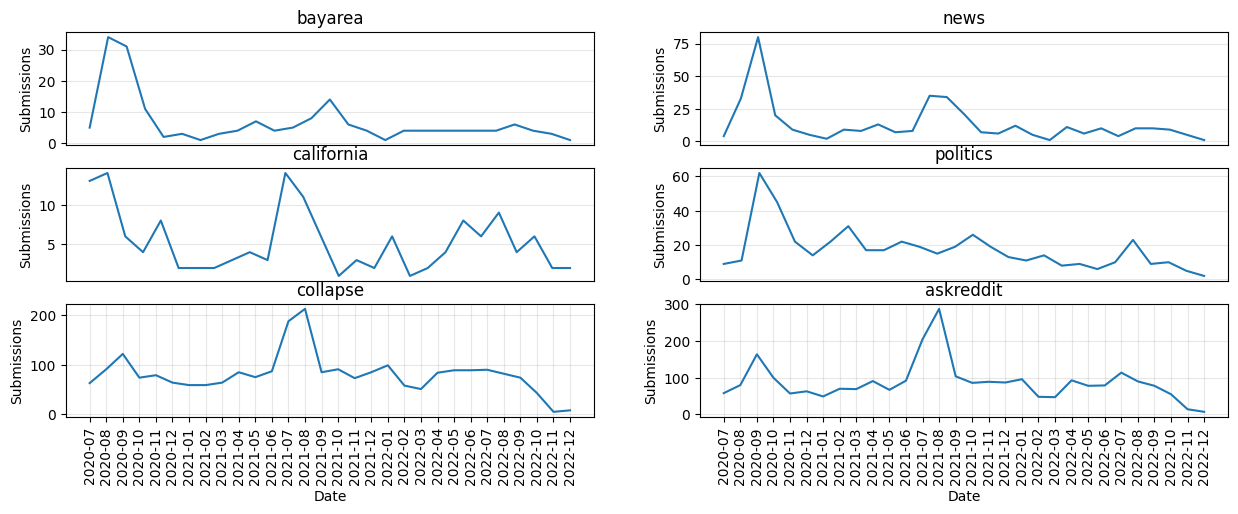

In [10]:
figure, axis = plt.subplots(3, 2, figsize=(15, 5))
x_ticks = []
                            
for index, df in enumerate(data):
    subs_df = evaluate_subs_per_month(df)

    ax = 0 if index < 3 else 1
    i = index % 3
    axis[i, ax].plot(subs_df["date"], subs_df["count"])

    # no x ticks
    axis[i, ax].set_xticks([])
    x_ticks = subs_df["date"].tolist() # pezzotto

    axis[i, ax].set_title(subreddits[index])
    axis[i, ax].set_ylabel("Submissions")

    # light gray overlay grid
    axis[i, ax].grid(True, alpha=0.3)


axis[2, 0].set_xlabel("Date")
axis[2, 0].set_xticks(x_ticks)
axis[2, 0].tick_params(axis='x', rotation=90)

axis[2, 1].set_xlabel("Date")
axis[2, 1].set_xticks(x_ticks)
axis[2, 1].tick_params(axis='x', rotation=90)

#### Submissions lifespan per month

In [11]:
def eval_lifespan_dist(df, base_threads_path):
    _df = df.copy()

    _df["date"] = pd.to_datetime(_df["created_at"])
    _df["date"] = _df["date"].dt.strftime("%Y-%m")

    gdf = _df.groupby("date")

    lifespan_per_month = {}

    for date, group in gdf:
        #print(date, len(group))

        lifespan_per_month[date] = []

        for index, row in group.iterrows():
            sub_id = row["sub_id"]
            creation_date = pd.to_datetime(row["created_at"])

            # load conversation thread
            thread_file = os.path.join(base_threads_path, sub_id, row["sub_id"] + ".csv")
            thread_df = pd.read_csv(thread_file)
            thread_df["created_at"] = pd.to_datetime(thread_df["created_at"])

            # get last comment's date
            last_comment_date = thread_df["created_at"].max()

            # evaluate day elapsed between creation and last comment
            lifespan = last_comment_date - creation_date
            lifespan_per_month[date].append(lifespan.days)

            #print(row["sub_id"], row["created_at"], last_comment_date, lifespan)

    return lifespan_per_month

In [12]:
subreddits_lifespan_per_month = [eval_lifespan_dist(df, base_threads_paths[index]) for index, df in enumerate(data)]

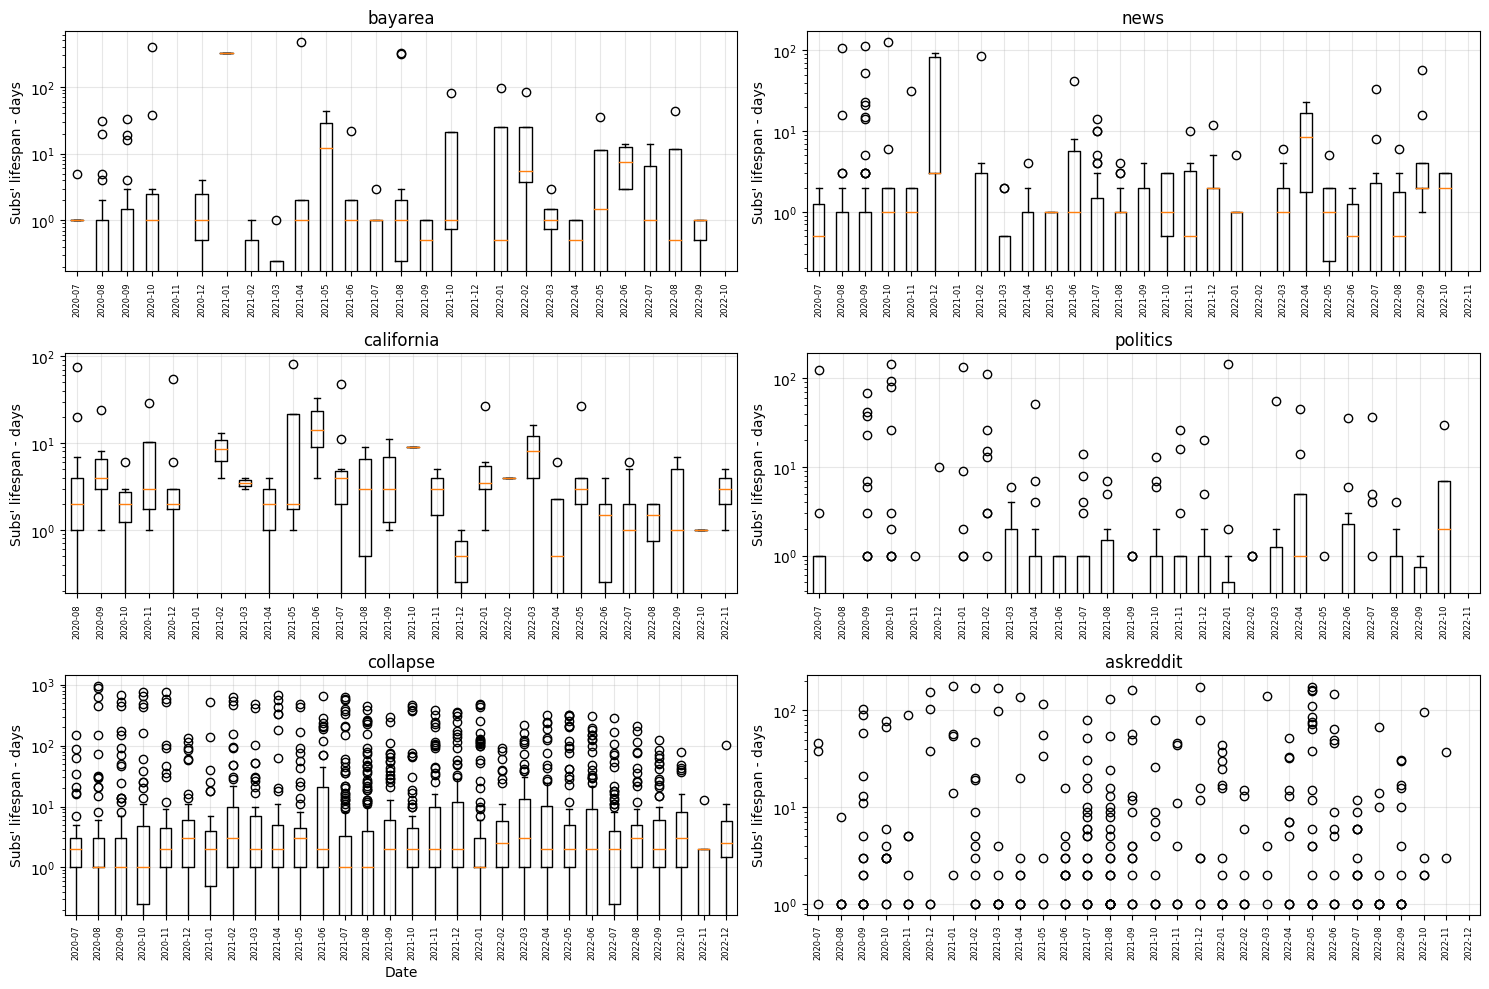

In [13]:
figure, axis = plt.subplots(3, 2, figsize=(15, 10))

for index, df in enumerate(data):

    lifespan_per_month = subreddits_lifespan_per_month[index] #eval_lifespan_dist(df, base_threads_paths[index])
    
    ax = 0 if index < 3 else 1
    i = index % 3

    axis[i, ax].boxplot(lifespan_per_month.values())

    axis[i, ax].set_title(subreddits[index])
    axis[i, ax].set_ylabel("Subs' lifespan - days")

    axis[i, ax].set_xticklabels(lifespan_per_month.keys())
    axis[i, ax].tick_params(axis='x', rotation=90, labelsize=6)

    axis[i, ax].set_yscale("log")

    # light gray overlay grid
    axis[i, ax].grid(True, alpha=0.3)

axis[2, 0].set_xlabel("Date")
# axis[2, 0].set_xticklabels(x_ticks)
# axis[2, 0].tick_params(axis='x', rotation=90)

figure.tight_layout()

# axis[2, 1].set_xlabel("Date")
# axis[2, 1].set_xticklabels(x_ticks)
# axis[2, 1].tick_params(axis='x', rotation=90);
    

### User-related plots

#### Users' lifespan considering all period

In [14]:
# users_lifespan = {user => (first_activity_date, last_activity_date)}
users_lifespan = {}

users_lifespan_bayarea = {}
users_lifespan_california = {}
users_lifespan_collapse = {}
users_lifespan_news = {}
users_lifespan_politics = {}
users_lifespan_askreddit = {}

In [15]:
def update_activity(user_id, users_dict, activity_date):
    if user_id in users_dict:
        first_activity_date = users_dict[user_id][0]
        last_activity_date = users_dict[user_id][1]

        if activity_date < first_activity_date:
            users_dict[user_id] = (activity_date, last_activity_date)
        elif activity_date > last_activity_date:
            users_dict[user_id] = (first_activity_date, activity_date)
    else:
        users_dict[user_id] = (activity_date, activity_date)

In [16]:
# let's add infos from submission data first
for index, df in enumerate(data):
    print("Processing", subreddits[index])

    for i, row in df.iterrows():
        user_id = row["author_id"]

        if user_id not in redditors_to_include:
            continue

        activity_date = pd.to_datetime(row["created_at"])

        # add data to the specific subreddit dict
        sub_dict = eval("users_lifespan_" + subreddits[index])
        update_activity(user_id, sub_dict, activity_date)
        
        # add data to the general dict
        update_activity(user_id, users_lifespan, activity_date)

Processing bayarea
Processing california
Processing collapse
Processing news
Processing politics
Processing askreddit


In [17]:
# now we add infos from comments data
for index, thread_dir in enumerate(base_threads_paths):
    print("Processing", subreddits[index])
    
    thread_ids = os.listdir(thread_dir)
    
    for thread_id in thread_ids:
        thread_file = os.path.join(thread_dir, thread_id, thread_id + ".csv")
        thread_df = pd.read_csv(thread_file)

        for i, row in thread_df.iterrows():
            user_id = row["author_id"]

            if user_id not in redditors_to_include:
                continue

            activity_date = pd.to_datetime(row["created_at"])

            # add data to the specific subreddit dict
            sub_dict = eval("users_lifespan_" + subreddits[index])
            update_activity(user_id, sub_dict, activity_date)

            # add data to the general dict
            update_activity(user_id, users_lifespan, activity_date)

Processing bayarea
Processing california
Processing collapse
Processing news
Processing politics
Processing askreddit


In [18]:
# evaluating users' lifespan in days
users_lifespan_days = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan.items()}

users_lifespan_days_bayarea = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_bayarea.items()}
users_lifespan_days_california = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_california.items()}
users_lifespan_days_collapse = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_collapse.items()}
users_lifespan_days_news = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_news.items()}
users_lifespan_days_politics = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_politics.items()}
users_lifespan_days_askreddit = {user: (last_activity_date - first_activity_date).days for user, (first_activity_date, last_activity_date) in users_lifespan_askreddit.items()}

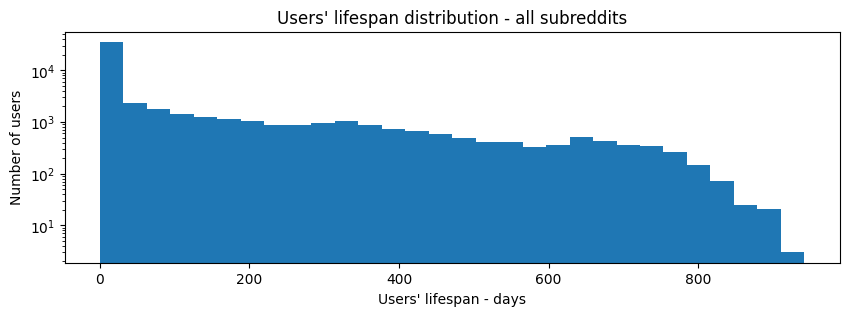

In [19]:
# here we plot the overal lifespan distribution with a histogram
# here, we consider all the subreddits together
figure, axis = plt.subplots(figsize=(10, 3))

axis.hist(users_lifespan_days.values(), bins=30)
axis.set_yscale("log")

axis.set_title("Users' lifespan distribution - all subreddits")
axis.set_xlabel("Users' lifespan - days")
axis.set_ylabel("Number of users");

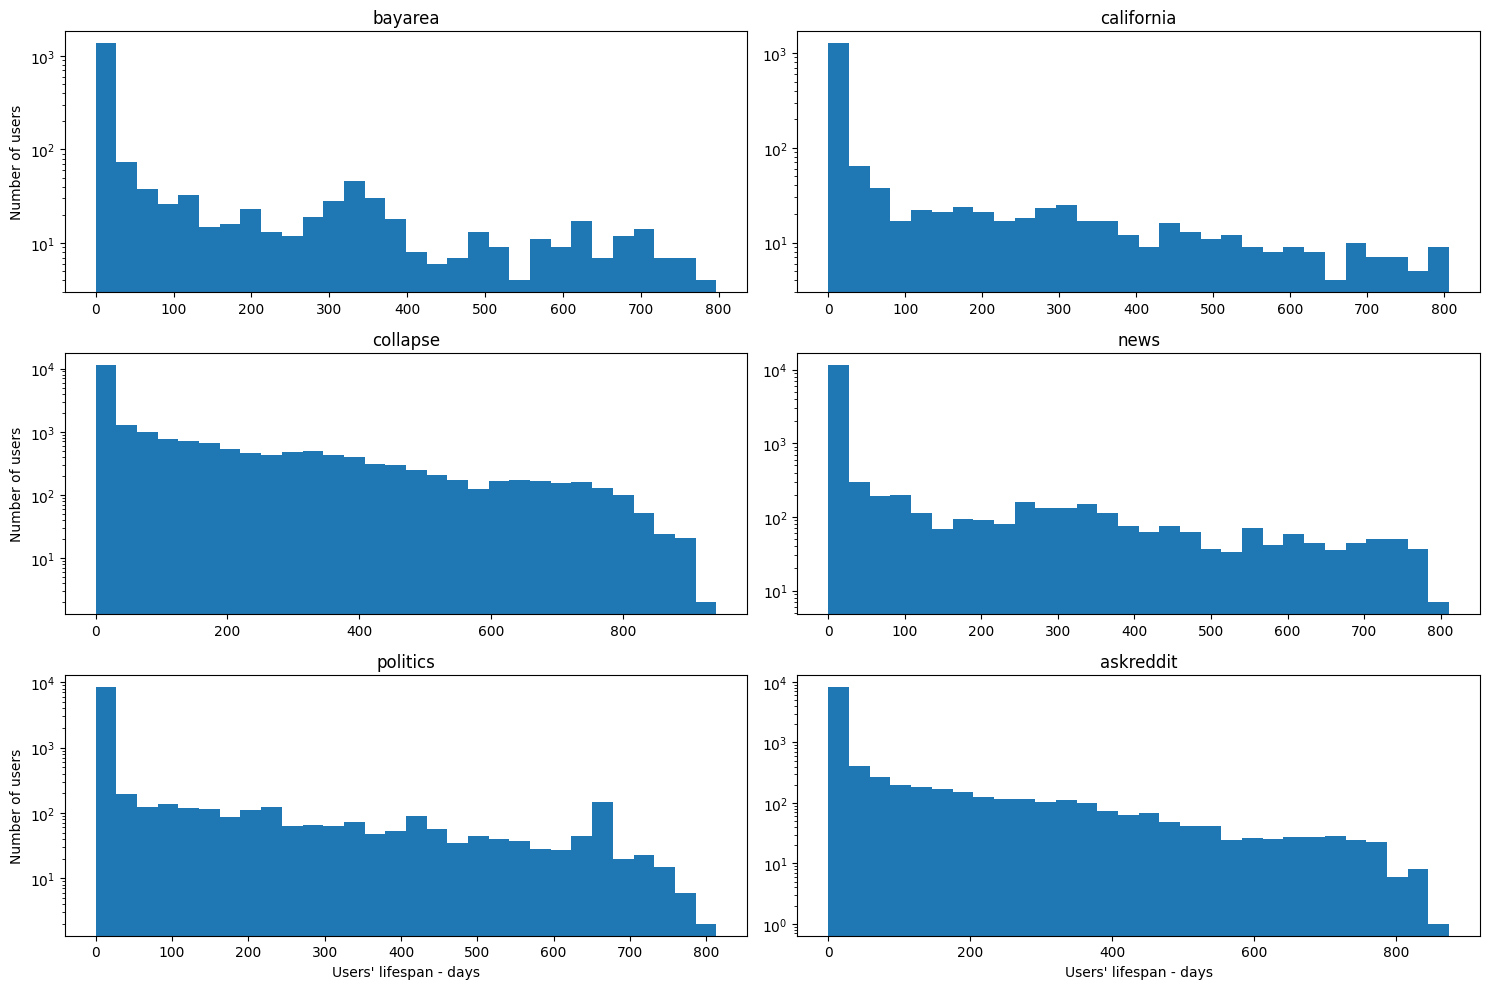

In [24]:
# here we plot the overal lifespan distribution with a histogram
# here, we consider a single subreddit at a time
figure, axis = plt.subplots(3, 2, figsize=(15, 10))

for index, subreddit in enumerate(subreddits):
    data_dict = eval("users_lifespan_days_" + subreddit)
    row = index // 2
    col = index % 2

    axis[row, col].hist(data_dict.values(), bins=30)
    axis[row, col].set_yscale("log")
    axis[row, col].set_title(subreddit)
    
    if col == 0:
        axis[row, col].set_ylabel("Number of users")

axis[2, 0].set_xlabel("Users' lifespan - days")
axis[2, 1].set_xlabel("Users' lifespan - days")

figure.tight_layout()

In [ ]:
# for the most active users, we can analyze whether they are active in the same period 
# ?
